In [1]:
#import all packages
import os
import json
import random
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from random import uniform
import seaborn as sns
import ipywidgets
import geopandas
from ipyleaflet import Map, GeoJSON, basemaps, Marker, MarkerCluster, FullScreenControl, CircleMarker
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
from pyod.models.abod import ABOD
from scipy import stats

# Data Processing and Variable Selections

In [2]:
#import dataset and print 
df_whole = pd.read_csv("Salary_alldata.csv")
df_whole.head(n=5)

timestamp    company level                         title  \
0   6/7/2017 11:33:27     Oracle    L3               Product Manager   
1  6/10/2017 17:11:29       eBay  SE 2             Software Engineer   
2  6/11/2017 14:53:57     Amazon    L7               Product Manager   
3   6/17/2017 0:23:14      Apple    M1  Software Engineering Manager   
4  6/20/2017 10:58:51  Microsoft    60             Software Engineer   

   totalyearlycompensation           location  yearsofexperience  \
0                   127000   Redwood City, CA                1.5   
1                   100000  San Francisco, CA                5.0   
2                   310000        Seattle, WA                8.0   
3                   372000      Sunnyvale, CA                7.0   
4                   157000  Mountain View, CA                5.0   

   yearsatcompany  tag  basesalary  ...  Doctorate_Degree  Highschool  \
0             1.5  NaN    107000.0  ...                 0           0   
1             3.0  NaN         0.0  ...                 0           0   
2             0.0  NaN    155000.0  ...                 0           0   
3             5.0  NaN    157000.0  ...                 0           0   
4             3.0  NaN         0.0  ...                 0           0   

  Some_College Race_Asian  Race_White  Race_Two_Or_More  Race_Black  \
0            0          0           0                 0           0   
1            0          0           0                 0           0   
2            0          0           0                 0           0   
3            0          0           0                 0           0   
4            0          0           0                 0           0   

   Race_Hispanic  Race  Education  
0              0   NaN        NaN  
1              0   NaN        NaN  
2              0   NaN        NaN  
3              0   NaN        NaN  
4              0   NaN        NaN  

[5 rows x 29 columns]

In [3]:
#show positions and each count
title = pd.crosstab(index=df_whole['title'], columns='count')
title

col_0                         count
title                              
Business Analyst                885
Data Scientist                 2578
Hardware Engineer              2200
Human Resources                 364
Management Consultant           976
Marketing                       710
Mechanical Engineer             490
Product Designer               1516
Product Manager                4673
Recruiter                       451
Sales                           461
Software Engineer             41231
Software Engineering Manager   3569
Solution Architect             1157
Technical Program Manager      1381

In [4]:
#pick only titles = data scientist based on the project topic
df_ds = df_whole[df_whole['title'].str.match('Data Scientist')]
df_ds.head(n=5)

timestamp    company   level           title  \
419   6/5/2018 14:06:30   LinkedIn  Senior  Data Scientist   
440    6/8/2018 9:49:25  Microsoft      64  Data Scientist   
444   6/8/2018 17:55:09       ebay      26  Data Scientist   
454  6/10/2018 19:39:35    Twitter   Staff  Data Scientist   
495  6/17/2018 11:39:38   Facebook       5  Data Scientist   

     totalyearlycompensation           location  yearsofexperience  \
419                   233000  San Francisco, CA                4.0   
440                   218000        Seattle, WA               11.0   
444                   180000       San Jose, CA               10.0   
454                   500000  San Francisco, CA                4.0   
495                   370000        Seattle, WA                8.0   

     yearsatcompany            tag  basesalary  ...  Doctorate_Degree  \
419             0.0  Data Analysis    162000.0  ...                 0   
440            11.0        ML / AI    165000.0  ...                 0   
444             5.0            NaN         0.0  ...                 0   
454             4.0        ML / AI    200000.0  ...                 0   
495             3.0            NaN    190000.0  ...                 0   

     Highschool Some_College Race_Asian  Race_White  Race_Two_Or_More  \
419           0            0          0           0                 0   
440           0            0          0           0                 0   
444           0            0          0           0                 0   
454           0            0          0           0                 0   
495           0            0          0           0                 0   

     Race_Black  Race_Hispanic  Race  Education  
419           0              0   NaN        NaN  
440           0              0   NaN        NaN  
444           0              0   NaN        NaN  
454           0              0   NaN        NaN  
495           0              0   NaN        NaN  

[5 rows x 29 columns]

In [5]:
#pick data sceintist positions in the U.S. only
#find the location length for each cell
df_ds['location_length'] = df_ds['location'].str.split(",").str.len()
#pick only the rows with location length equals 2 (in the U.S)
df_ds = df_ds[df_ds.location_length!= 3]
df_ds

/var/folders/3n/bgfqg8rx1h30s2swb06_wwz00000gn/T/ipykernel_33920/669398340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ds['location_length'] = df_ds['location'].str.split(",").str.len()


timestamp    company                        level  \
419     6/5/2018 14:06:30   LinkedIn                       Senior   
440      6/8/2018 9:49:25  Microsoft                           64   
444     6/8/2018 17:55:09       ebay                           26   
454    6/10/2018 19:39:35    Twitter                        Staff   
495    6/17/2018 11:39:38   Facebook                            5   
...                   ...        ...                          ...   
62233  2/10/2019 22:46:28   Deloitte            Senior Consultant   
62240  3/26/2019 17:25:02        IBM                            8   
62285  7/16/2018 20:11:40        ADP           Sr UX Researcher 4   
62529  6/12/2018 20:54:06     Google                           T6   
62623  8/19/2018 20:31:37   Illumina  Bioinformatics Scientist II   

                title  totalyearlycompensation           location  \
419    Data Scientist                   233000  San Francisco, CA   
440    Data Scientist                   218000        Seattle, WA   
444    Data Scientist                   180000       San Jose, CA   
454    Data Scientist                   500000  San Francisco, CA   
495    Data Scientist                   370000        Seattle, WA   
...               ...                      ...                ...   
62233  Data Scientist                   190000        Chicago, IL   
62240  Data Scientist                   155000     Washington, DC   
62285  Data Scientist                   185000       Roseland, NJ   
62529  Data Scientist                   685000       Kirkland, WA   
62623  Data Scientist                   175000      San Diego, CA   

       yearsofexperience  yearsatcompany             tag  basesalary  ...  \
419                  4.0             0.0   Data Analysis    162000.0  ...   
440                 11.0            11.0         ML / AI    165000.0  ...   
444                 10.0             5.0             NaN         0.0  ...   
454                  4.0             4.0         ML / AI    200000.0  ...   
495                  8.0             3.0             NaN    190000.0  ...   
...                  ...             ...             ...         ...  ...   
62233                3.0             0.0         ML / AI    160000.0  ...   
62240                5.0             2.0         ML / AI    141000.0  ...   
62285                8.0             2.0     UX Research    150000.0  ...   
62529               22.0             2.0         ML / AI    221000.0  ...   
62623                6.0             2.0  Bioinformatics    135000.0  ...   

       Highschool  Some_College Race_Asian Race_White  Race_Two_Or_More  \
419             0             0          0          0                 0   
440             0             0          0          0                 0   
444             0             0          0          0                 0   
454             0             0          0          0                 0   
495             0             0          0          0                 0   
...           ...           ...        ...        ...               ...   
62233           0             0          0          0                 0   
62240           0             0          0          0                 0   
62285           0             0          0          0                 0   
62529           0             0          0          0                 0   
62623           0             0          0          0                 0   

       Race_Black  Race_Hispanic  Race  Education  location_length  
419             0              0   NaN        NaN                2  
440             0              0   NaN        NaN                2  
444             0              0   NaN        NaN                2  
454             0              0   NaN        NaN                2  
495             0              0   NaN        NaN                2  
...           ...            ...   ...        ...              ...  
62233           0              0   NaN        NaN

### Variable Selection
#### Drop columns

In [6]:
#check if it is nessesary to include some columns
#level
level = pd.crosstab(index=df_ds['level'], columns='count')
level

col_0  count
level       
0          1
1         11
10         1
107        1
10P        1
...      ...
staff      2
x3         1
x4         2
x6         1
x7         1

[374 rows x 1 columns]

In [7]:
#company
company = pd.crosstab(index=df_ds['company'], columns='count')
company

col_0        count
company           
3M               1
3m               1
7-Eleven         1
ABB              1
ADP              3
...            ...
realtor.com      1
roche            1
target           1
ubs              1
wish             1

[397 rows x 1 columns]

In [8]:
#pick colmns for the data analysis
#drop unnecessary columns (6): cityid, dmaid, tag, otherdetails, rowNumber, location_length
#drop repeating columns (10): Masters_Degree, Bachelors_Degree, Doctorate_Degree, Highschool, Some_College, Race_Asian, Race_White, Race_Two_Or_More, Race_Black, Race_Hispanic
#drop categarical columns with kinds more than 10 (2): company, level
df_ds = df_ds.drop(['cityid', 'dmaid','company', 'level', 'tag', 'otherdetails', 'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'location_length'], axis=1)
df_ds.head(n=5)

timestamp           title  totalyearlycompensation  \
419   6/5/2018 14:06:30  Data Scientist                   233000   
440    6/8/2018 9:49:25  Data Scientist                   218000   
444   6/8/2018 17:55:09  Data Scientist                   180000   
454  6/10/2018 19:39:35  Data Scientist                   500000   
495  6/17/2018 11:39:38  Data Scientist                   370000   

              location  yearsofexperience  yearsatcompany  basesalary  \
419  San Francisco, CA                4.0             0.0    162000.0   
440        Seattle, WA               11.0            11.0    165000.0   
444       San Jose, CA               10.0             5.0         0.0   
454  San Francisco, CA                4.0             4.0    200000.0   
495        Seattle, WA                8.0             3.0    190000.0   

     stockgrantvalue    bonus  gender Race Education  
419         220000.0  10000.0    Male  NaN       NaN  
440          28000.0  23000.0    Male  NaN       NaN  
444              0.0      0.0  Female  NaN       NaN  
454         280000.0  20000.0    Male  NaN       NaN  
495         140000.0  40000.0    Male  NaN       NaN

In [9]:
#print the column names in the dataframe
for col in df_ds.columns:
    print(col)

timestamp
title
totalyearlycompensation
location
yearsofexperience
yearsatcompany
basesalary
stockgrantvalue
bonus
gender
Race
Education


#### Create Columns

1. Salary

In [10]:
#since there are 4 columns for salaries and many zeros for stock grant value and bonus
#create a new column for salary using total yearly compensation minus strock value and bonus
df_ds["salary"] = df_ds["totalyearlycompensation"] - df_ds["stockgrantvalue"] - df_ds["bonus"]

#drop the redundant columns for salary 
df_ds = df_ds.drop(['basesalary', 'totalyearlycompensation', 'stockgrantvalue', 'bonus'], axis=1)

2. Years

In [11]:
#create a new column with only years
years =['2018', '2019', '2020', '2021']

def matcher1(x):
    for i in years:
        if i in x:
            return i
    else:
        return np.nan

df_ds['year'] = df_ds['timestamp'].apply(matcher1)

#show info about years
year = pd.crosstab(index=df_ds['year'], columns='count')
year

col_0  count
year        
2018     124
2019     404
2020     854
2021     845

3. Pandemic

In [12]:
#create the pandemic column
df_ds['pandemic'] = np.where((df_ds['year'] == '2018') | (df_ds['year'] == '2019'), 0, 1)

#show info about pandemic
pandemic = pd.crosstab(index=df_ds['pandemic'], columns='count')
pandemic

col_0     count
pandemic       
0           528
1          1699

4. States

In [13]:
#create a new column with only states
states =['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'] 

def matcher2(x):
    for i in states:
        if i in x:
            return i
    else:
        return np.NaN

df_ds['states'] = df_ds['location'].apply(matcher2)
df_ds['states'] = df_ds['states'].astype(str)

#remove the rows that not in the US
df_ds = df_ds[df_ds.states != 'nan']

#print info for states
state = pd.crosstab(index=df_ds['states'], columns='count')
state


col_0   count
states       
AL          3
AR         14
AZ         13
CA        960
CO         23
CT          7
DE          5
FL         10
GA         31
ID          3
IL         48
IN          4
KS          1
KY          1
MA         70
MD          4
MI         12
MN          9
MO          4
MS          1
NC         33
NH          1
NJ         18
NM          1
NV          2
NY        254
OH         14
OK          2
OR         33
PA         19
RI          2
SC          1
TN          3
TX         81
UT          4
VA         41
WA        450
WI          2

5. Divisions

In [14]:
#create regional variable based on the 9 regions
moutain =['NV', 'ID', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
pacific = ['WA', 'OR', 'CA', 'HI', 'AK']
wnc =['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']
wsc = ['TX', 'OK', 'AR', 'LA']
enc = ['WI', 'IL', 'IN', 'MI', 'OH']
esc = ['KY', 'TN', 'MS', 'AL']
ma = ['NY', 'PA', 'NJ']
sa = ['WV', 'MD', 'DE', 'DC', 'VA', 'NC', 'SC', 'GA', 'FL']
ne = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

def matcher3(x):
    for i in moutain:
        if i in x:
            return 'MOUTAIN'
    for i in pacific:
        if i in x:
            return 'PACIFIC'
    for i in wnc:
        if i in x:
            return 'WestNorthCentral'
    for i in wsc:
        if i in x:
            return 'WestSouthCentral'
    for i in enc:
        if i in x:
            return 'EastNorthCentral'
    for i in esc:
        if i in x:
            return 'EastSouthCentral'
    for i in ma:
        if i in x:
            return 'MiddleAtlantic'
    for i in sa:
        if i in x:
            return 'SouthAtlantic'
    for i in ne:
        if i in x:
            return 'NewEngland'
    else:
        return np.nan

df_ds['region'] = df_ds['states'].apply(matcher3)

In [15]:
#show basic info for the cleaned dataset
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 419 to 62623
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          2184 non-null   object 
 1   title              2184 non-null   object 
 2   location           2184 non-null   object 
 3   yearsofexperience  2184 non-null   float64
 4   yearsatcompany     2184 non-null   float64
 5   gender             1460 non-null   object 
 6   Race               721 non-null    object 
 7   Education          1153 non-null   object 
 8   salary             2184 non-null   float64
 9   year               2184 non-null   object 
 10  pandemic           2184 non-null   int64  
 11  states             2184 non-null   object 
 12  region             2184 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 238.9+ KB


In [16]:
#show the descriptive statestics for numerical variables
df_ds.describe()

yearsofexperience  yearsatcompany         salary     pandemic
count        2184.000000     2184.000000    2184.000000  2184.000000
mean            5.038919        2.059684  156333.333333     0.761905
std             4.119476        2.268014   58112.687430     0.426015
min             0.000000        0.000000    3000.000000     0.000000
25%             2.000000        0.250000  126750.000000     1.000000
50%             4.000000        2.000000  150000.000000     1.000000
75%             7.000000        3.000000  175000.000000     1.000000
max            34.000000       20.000000  700000.000000     1.000000

In [17]:
#Pandas Profiling to generate a better report
pp.ProfileReport(df_ds)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Visualization

### Seaborn

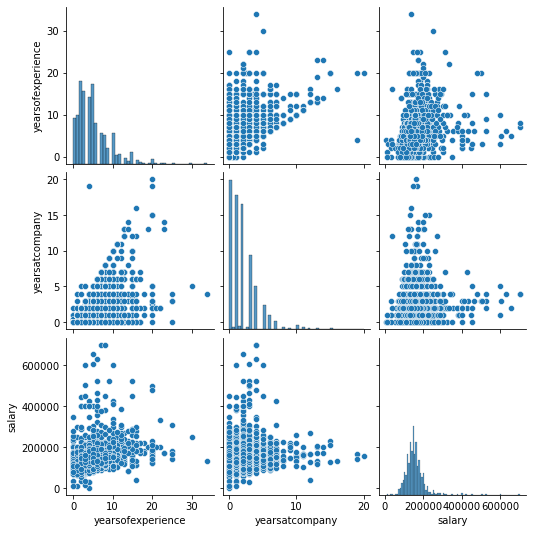

In [18]:
#create seaborn to visualize all variable pairs (4 numerical variables)
df1 = df_ds[['yearsofexperience','yearsatcompany', 'salary', 'year']]
sns.pairplot(df1)

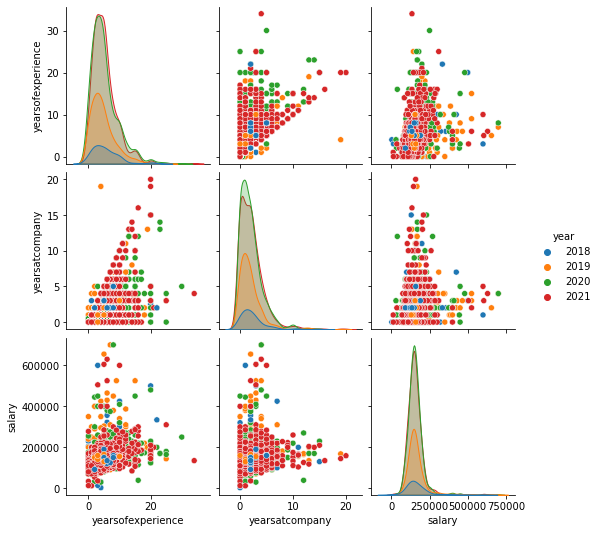

In [19]:
#add year to seaborn
sns.pairplot(df1, hue="year")

### Salary and Years


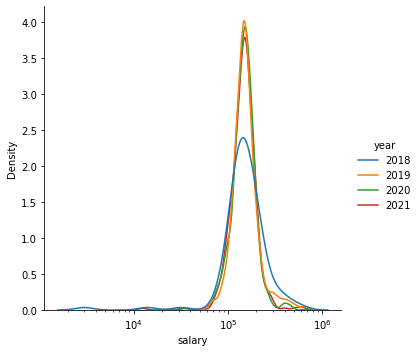

In [20]:
#salary in Kernel density based on year
sns.displot(data = df_ds, x="salary", kind = "kde", hue = "year", common_norm=False, log_scale=True)

### Salary and Pandamic since 2020

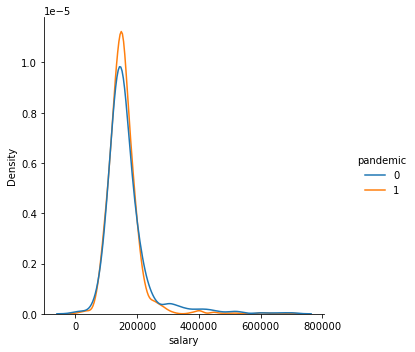

In [21]:
#salary in Kernel density based on pandemic
sns.displot(data = df_ds, x="salary", kind="kde", hue = "pandemic", common_norm=False)

#### Salary and States

In [22]:
#create a new data frame based on states and salary
df_states = pd.DataFrame(df_ds.groupby(['states'])['salary'].mean()).reset_index()
df_states1 = pd.crosstab(index=df_ds['states'], columns='count').reset_index()
df_states['count'] = df_states1['count']

In [23]:
#define latitude column
df_states.loc[df_states["states"] == 'AK', 'latitude'] = 61.37
df_states.loc[df_states["states"] == 'AL', 'latitude'] = 32.81
df_states.loc[df_states["states"] == 'AR', 'latitude'] = 34.97
df_states.loc[df_states["states"] == 'AZ', 'latitude'] = 33.73
df_states.loc[df_states["states"] == 'CA', 'latitude'] = 36.12
df_states.loc[df_states["states"] == 'CO', 'latitude'] = 39.06
df_states.loc[df_states["states"] == 'CT', 'latitude'] = 41.60
df_states.loc[df_states["states"] == 'DE', 'latitude'] = 39.32
df_states.loc[df_states["states"] == 'FL', 'latitude'] = 27.77
df_states.loc[df_states["states"] == 'GA', 'latitude'] = 33.04
df_states.loc[df_states["states"] == 'HI', 'latitude'] = 21.09
df_states.loc[df_states["states"] == 'IA', 'latitude'] = 44.01
df_states.loc[df_states["states"] == 'ID', 'latitude'] = 44.24
df_states.loc[df_states["states"] == 'IL', 'latitude'] = 40.35
df_states.loc[df_states["states"] == 'IN', 'latitude'] = 39.85
df_states.loc[df_states["states"] == 'KS', 'latitude'] = 38.53
df_states.loc[df_states["states"] == 'KY', 'latitude'] = 37.67
df_states.loc[df_states["states"] == 'LA', 'latitude'] = 31.17
df_states.loc[df_states["states"] == 'MA', 'latitude'] = 42.45
df_states.loc[df_states["states"] == 'MI', 'latitude'] = 43.44
df_states.loc[df_states["states"] == 'MN', 'latitude'] = 45.69
df_states.loc[df_states["states"] == 'MO', 'latitude'] = 38.46
df_states.loc[df_states["states"] == 'NC', 'latitude'] = 35.63
df_states.loc[df_states["states"] == 'ND', 'latitude'] = 47.54
df_states.loc[df_states["states"] == 'NE', 'latitude'] = 41.13
df_states.loc[df_states["states"] == 'NJ', 'latitude'] = 40.03
df_states.loc[df_states["states"] == 'NY', 'latitude'] = 42.17
df_states.loc[df_states["states"] == 'OK', 'latitude'] = 35.57
df_states.loc[df_states["states"] == 'OR', 'latitude'] = 44.57
df_states.loc[df_states["states"] == 'PA', 'latitude'] = 40.59
df_states.loc[df_states["states"] == 'RI', 'latitude'] = 41.68
df_states.loc[df_states["states"] == 'TN', 'latitude'] = 35.75
df_states.loc[df_states["states"] == 'TX', 'latitude'] = 31.05
df_states.loc[df_states["states"] == 'UT', 'latitude'] = 40.15
df_states.loc[df_states["states"] == 'VA', 'latitude'] = 37.77
df_states.loc[df_states["states"] == 'WA', 'latitude'] = 47.40
df_states.loc[df_states["states"] == 'MD', 'latitude'] = 39.05
df_states.loc[df_states["states"] == 'MS', 'latitude'] = 33.00
df_states.loc[df_states["states"] == 'NH', 'latitude'] = 44.00
df_states.loc[df_states["states"] == 'NM', 'latitude'] = 34.31
df_states.loc[df_states["states"] == 'NA', 'latitude'] = 39.88
df_states.loc[df_states["states"] == 'OH', 'latitude'] = 40.37
df_states.loc[df_states["states"] == 'SC', 'latitude'] = 33.84
df_states.loc[df_states["states"] == 'WI', 'latitude'] = 44.50

In [24]:
#define longitude column
df_states.loc[df_states["states"] == 'AK', 'longitude'] = -152.40
df_states.loc[df_states["states"] == 'AL', 'longitude'] = -86.79
df_states.loc[df_states["states"] == 'AR', 'longitude'] = -92.37
df_states.loc[df_states["states"] == 'AZ', 'longitude'] = -111.43
df_states.loc[df_states["states"] == 'CA', 'longitude'] = -119.68
df_states.loc[df_states["states"] == 'CO', 'longitude'] = -105.31
df_states.loc[df_states["states"] == 'CT', 'longitude'] = -72.76
df_states.loc[df_states["states"] == 'DE', 'longitude'] = -75.51
df_states.loc[df_states["states"] == 'FL', 'longitude'] = -81.69
df_states.loc[df_states["states"] == 'GA', 'longitude'] = -83.64
df_states.loc[df_states["states"] == 'HI', 'longitude'] = -157.50
df_states.loc[df_states["states"] == 'IA', 'longitude'] = -93.21
df_states.loc[df_states["states"] == 'ID', 'longitude'] = -114.48
df_states.loc[df_states["states"] == 'IL', 'longitude'] = -88.99
df_states.loc[df_states["states"] == 'IN', 'longitude'] = -86.26
df_states.loc[df_states["states"] == 'KS', 'longitude'] = -96.73
df_states.loc[df_states["states"] == 'KY', 'longitude'] = -84.67
df_states.loc[df_states["states"] == 'LA', 'longitude'] = -91.87
df_states.loc[df_states["states"] == 'MA', 'longitude'] = -72.53
df_states.loc[df_states["states"] == 'MI', 'longitude'] = -84.53
df_states.loc[df_states["states"] == 'MN', 'longitude'] = -93.90
df_states.loc[df_states["states"] == 'MO', 'longitude'] = -92.29
df_states.loc[df_states["states"] == 'NC', 'longitude'] = -79.81
df_states.loc[df_states["states"] == 'ND', 'longitude'] = -99.78
df_states.loc[df_states["states"] == 'NE', 'longitude'] = -98.27
df_states.loc[df_states["states"] == 'NJ', 'longitude'] = -74.52
df_states.loc[df_states["states"] == 'NY', 'longitude'] = -74.95
df_states.loc[df_states["states"] == 'OK', 'longitude'] = -96.93
df_states.loc[df_states["states"] == 'OR', 'longitude'] = -122.07
df_states.loc[df_states["states"] == 'PA', 'longitude'] = -77.21
df_states.loc[df_states["states"] == 'RI', 'longitude'] = -71.51
df_states.loc[df_states["states"] == 'TN', 'longitude'] = -86.69
df_states.loc[df_states["states"] == 'TX', 'longitude'] = -97.56
df_states.loc[df_states["states"] == 'UT', 'longitude'] = -111.86
df_states.loc[df_states["states"] == 'VA', 'longitude'] = -78.17
df_states.loc[df_states["states"] == 'WA', 'longitude'] = -121.49
df_states.loc[df_states["states"] == 'MD', 'longitude'] = -76.64
df_states.loc[df_states["states"] == 'MS', 'longitude'] = -90.00
df_states.loc[df_states["states"] == 'NH', 'longitude'] = -71.50
df_states.loc[df_states["states"] == 'NM', 'longitude'] = -106.02
df_states.loc[df_states["states"] == 'NV', 'longitude'] = -117.22
df_states.loc[df_states["states"] == 'OH', 'longitude'] = -83.00
df_states.loc[df_states["states"] == 'SC', 'longitude'] = -81.16
df_states.loc[df_states["states"] == 'WI', 'longitude'] = -89.50

In [25]:
#create a square root of states counts
df_states['squarecounts'] = df_states['count']**(1/2)
#print the state dataframe
df_states

states         salary  count  latitude  longitude  squarecounts
0      AL  149000.000000      3     32.81     -86.79      1.732051
1      AR  126642.857143     14     34.97     -92.37      3.741657
2      AZ  105384.615385     13     33.73    -111.43      3.605551
3      CA  176467.708333    960     36.12    -119.68     30.983867
4      CO  132565.217391     23     39.06    -105.31      4.795832
5      CT  116428.571429      7     41.60     -72.76      2.645751
6      DE  115000.000000      5     39.32     -75.51      2.236068
7      FL  107700.000000     10     27.77     -81.69      3.162278
8      GA  121806.451613     31     33.04     -83.64      5.567764
9      ID  103333.333333      3     44.24    -114.48      1.732051
10     IL  129708.333333     48     40.35     -88.99      6.928203
11     IN   42000.000000      4     39.85     -86.26      2.000000
12     KS  170000.000000      1     38.53     -96.73      1.000000
13     KY   85000.000000      1     37.67     -84.67      1.000000
14     MA  139085.714286     70     42.45     -72.53      8.366600
15     MD  116500.000000      4     39.05     -76.64      2.000000
16     MI  130916.666667     12     43.44     -84.53      3.464102
17     MN  100333.333333      9     45.69     -93.90      3.000000
18     MO  111250.000000      4     38.46     -92.29      2.000000
19     MS   70000.000000      1     33.00     -90.00      1.000000
20     NC  120363.636364     33     35.63     -79.81      5.744563
21     NH   34000.000000      1     44.00     -71.50      1.000000
22     NJ  147055.555556     18     40.03     -74.52      4.242641
23     NM  103000.000000      1     34.31    -106.02      1.000000
24     NV  124500.000000      2       NaN    -117.22      1.414214
25     NY  147712.598425    254     42.17     -74.95     15.937377
26     OH  115928.571429     14     40.37     -83.00      3.741657
27     OK  130000.000000      2     35.57     -96.93      1.414214
28     OR  145030.303030     33     44.57    -122.07      5.744563
29     PA  133368.421053     19     40.59     -77.21      4.358899
30     RI  107000.000000      2     41.68     -71.51      1.414214
31     SC  174000.000000      1     33.84     -81.16      1.000000
32     TN  112000.000000      3     35.75     -86.69      1.732051
33     TX  121407.407407     81     31.05     -97.56      9.000000
34     UT  100500.000000      4     40.15    -111.86      2.000000
35     VA  120073.170732     41     37.77     -78.17      6.403124
36     WA  153684.444444    450     47.40    -121.49     21.213203
37     WI  111500.000000      2     44.50     -89.50      1.414214

In [26]:
#import map 
m = Map(center=(38, -98), zoom = 4)

m.add_control(FullScreenControl())

In [27]:
#add boundries of states to the map
with open('us_states.json', 'r', encoding = 'utf-8') as f:
    data = json.load(f)

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }

geo_json = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    },
    style_callback=random_color
)
m.add_layer(geo_json)

In [28]:
#add markers
##marker 1 for state counts circle
##marker 2 for state mean salaries
mrk1 = [];
mrk2 = [];

for data,row in df_states.iterrows():
    mrk1.append(CircleMarker(location = (row.latitude,row.longitude),radius = int(row.squarecounts)))    
    mrk2.append(Marker(location=(row.latitude,row.longitude),title=str(round(row.salary, 2))))
                
marker_cluster1 = MarkerCluster(markers=mrk1)
marker_cluster2 = MarkerCluster(markers=mrk2)

m.add_layer(marker_cluster1);
m.add_layer(marker_cluster2);

#print map
m

Map(center=[38, -98], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

# BLS Data Support

In [29]:
#import BLS data set
alldata = pd.read_excel('alldata2021.xlsx', na_values=["*"])

In [30]:
#select data scientist data
data_sci = alldata[alldata['OCC_TITLE'].str.match('Data Scientists')]

data_sci.head(n=5)

AREA AREA_TITLE  AREA_TYPE PRIM_STATE   NAICS  \
164     99       U.S.          1         US  000000   
165     99       U.S.          1         US  000000   
1562    99       U.S.          1         US  000001   
1563    99       U.S.          1         US  000001   
3206    99       U.S.          1         US      21   

                                        NAICS_TITLE  \
164                                  Cross-industry   
165                                  Cross-industry   
1562         Cross-industry, private ownership only   
1563         Cross-industry, private ownership only   
3206  Mining, Quarrying, and Oil and Gas Extraction   

                        I_GROUP  OWN_CODE OCC_CODE        OCC_TITLE  ...  \
164              cross-industry      1235  15-2050  Data Scientists  ...   
165              cross-industry      1235  15-2051  Data Scientists  ...   
1562  cross-industry, ownership         5  15-2050  Data Scientists  ...   
1563  cross-industry, ownership         5  15-2051  Data Scientists  ...   
3206                     sector         5  15-2050  Data Scientists  ...   

     H_MEDIAN H_PCT75 H_PCT90 A_PCT10 A_PCT25 A_MEDIAN A_PCT75 A_PCT90 ANNUAL  \
164     48.52   62.87   80.31   59430   77620   100910  130770  167040    NaN   
165     48.52   62.87   80.31   59430   77620   100910  130770  167040    NaN   
1562    48.73      63   80.67   59640   77750   101350  131040  167790    NaN   
1563    48.73      63   80.67   59640   77750   101350  131040  167790    NaN   
3206    49.05   62.85   78.09   61740   77750   102030  130720  162420    NaN   

      HOURLY  
164      NaN  
165      NaN  
1562     NaN  
1563     NaN  
3206     NaN  

[5 rows x 32 columns]

In [31]:
#show basic info for the dataset
data_sci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 164 to 365664
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          674 non-null    int64  
 1   AREA_TITLE    674 non-null    object 
 2   AREA_TYPE     674 non-null    int64  
 3   PRIM_STATE    674 non-null    object 
 4   NAICS         674 non-null    object 
 5   NAICS_TITLE   674 non-null    object 
 6   I_GROUP       674 non-null    object 
 7   OWN_CODE      674 non-null    int64  
 8   OCC_CODE      674 non-null    object 
 9   OCC_TITLE     674 non-null    object 
 10  O_GROUP       674 non-null    object 
 11  TOT_EMP       674 non-null    object 
 12  EMP_PRSE      674 non-null    object 
 13  JOBS_1000     248 non-null    object 
 14  LOC_QUOTIENT  248 non-null    object 
 15  PCT_TOTAL     416 non-null    object 
 16  PCT_RPT       416 non-null    object 
 17  H_MEAN        669 non-null    object 
 18  A_MEAN        669 non-nul

In [32]:
#show info about states (50 states and US)
state = pd.crosstab(index=data_sci['PRIM_STATE'], columns='count')
state

col_0       count
PRIM_STATE       
AK              3
AL              4
AR              1
AZ              5
CA             14
CO              5
CT              4
DC              2
DE              1
FL             14
GA              8
HI              2
IA              8
ID              2
IL              6
IN             12
KS              1
KY              5
LA              3
MA              4
MD              3
ME              4
MI             10
MN              2
MO              5
MS              3
MT              1
NC             10
ND              1
NE              4
NH              5
NJ              2
NM              2
NV              3
NY             10
OH             11
OK              6
OR              6
PA             10
RI              2
SC              6
SD              2
TN              5
TX              7
US            426
UT              4
VA              6
VT              2
WA              3
WI              7
WV              2

In [33]:
#print the summary table for mean annual wage
data_sci['A_MEAN'] = data_sci['A_MEAN'].astype(float)
data_sci[['A_MEAN']].describe()

/var/folders/3n/bgfqg8rx1h30s2swb06_wwz00000gn/T/ipykernel_33920/476194965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sci['A_MEAN'] = data_sci['A_MEAN'].astype(float)


A_MEAN
count     669.000000
mean    95376.980568
std     17027.970917
min     41910.000000
25%     82270.000000
50%     93470.000000
75%    108060.000000
max    157110.000000

In [34]:
#create a BLS dataframe for comparison
data_bls = pd.DataFrame(data_sci.groupby(['PRIM_STATE'])[['A_MEAN']].agg('mean'))
#round the value
data_bls['A_MEAN'] = round(data_bls['A_MEAN'], 2)
#create new column with state counts
data_bls['count'] = data_sci.groupby( [ "PRIM_STATE"] ).size()
#rename column
data_bls = pd.DataFrame(data_bls).reset_index()
data_bls = data_bls.rename(columns={"PRIM_STATE": "states"})
data_bls = data_bls.rename(columns={"A_MEAN": "a_salary"})

data_bls

states   a_salary  count
0      AK  107320.00      3
1      AL   85005.00      4
2      AR        NaN      1
3      AZ   90932.00      5
4      CA  117444.29     14
5      CO  103746.00      5
6      CT  103960.00      4
7      DC  120105.00      2
8      DE  127810.00      1
9      FL   87304.29     14
10     GA   92475.00      8
11     HI   84200.00      2
12     IA   81307.50      8
13     ID  100300.00      2
14     IL   92186.67      6
15     IN   73697.50     12
16     KS   93070.00      1
17     KY   73542.00      5
18     LA   80633.33      3
19     MA  104177.50      4
20     MD  117366.67      3
21     ME   91015.00      4
22     MI   81746.00     10
23     MN  106460.00      2
24     MO   85330.00      5
25     MS   81660.00      3
26     MT   77830.00      1
27     NC  104423.00     10
28     ND   94230.00      1
29     NE   78875.00      4
30     NH   94162.00      5
31     NJ  117865.00      2
32     NM   79245.00      2
33     NV   94603.33      3
34     NY  103943.00     10
35     OH   82260.00     11
36     OK   79773.33      6
37     OR   98273.33      6
38     PA   90059.00     10
39     RI  103745.00      2
40     SC   95440.00      6
41     SD   87305.00      2
42     TN   88864.00      5
43     TX  109372.86      7
44     US   96632.17    426
45     UT   82092.50      4
46     VA  105810.00      6
47     VT  113930.00      2
48     WA  128330.00      3
49     WI   75070.00      7
50     WV   62810.00      2

In [35]:
#merge the two datasets to compare mean yearly salary
df_bls1 = data_bls[['states', 'a_salary']]
df_states1 = df_states[['states', 'salary']]
df_merged = df_bls1.merge(df_states1)

#create the difference variable for the salary in BLS and level.fyi
df_merged['difference'] = abs(df_merged['a_salary'] - df_merged['salary'])

df_merged

states   a_salary         salary    difference
0      AL   85005.00  149000.000000  63995.000000
1      AR        NaN  126642.857143           NaN
2      AZ   90932.00  105384.615385  14452.615385
3      CA  117444.29  176467.708333  59023.418333
4      CO  103746.00  132565.217391  28819.217391
5      CT  103960.00  116428.571429  12468.571429
6      DE  127810.00  115000.000000  12810.000000
7      FL   87304.29  107700.000000  20395.710000
8      GA   92475.00  121806.451613  29331.451613
9      ID  100300.00  103333.333333   3033.333333
10     IL   92186.67  129708.333333  37521.663333
11     IN   73697.50   42000.000000  31697.500000
12     KS   93070.00  170000.000000  76930.000000
13     KY   73542.00   85000.000000  11458.000000
14     MA  104177.50  139085.714286  34908.214286
15     MD  117366.67  116500.000000    866.670000
16     MI   81746.00  130916.666667  49170.666667
17     MN  106460.00  100333.333333   6126.666667
18     MO   85330.00  111250.000000  25920.000000
19     MS   81660.00   70000.000000  11660.000000
20     NC  104423.00  120363.636364  15940.636364
21     NH   94162.00   34000.000000  60162.000000
22     NJ  117865.00  147055.555556  29190.555556
23     NM   79245.00  103000.000000  23755.000000
24     NV   94603.33  124500.000000  29896.670000
25     NY  103943.00  147712.598425  43769.598425
26     OH   82260.00  115928.571429  33668.571429
27     OK   79773.33  130000.000000  50226.670000
28     OR   98273.33  145030.303030  46756.973030
29     PA   90059.00  133368.421053  43309.421053
30     RI  103745.00  107000.000000   3255.000000
31     SC   95440.00  174000.000000  78560.000000
32     TN   88864.00  112000.000000  23136.000000
33     TX  109372.86  121407.407407  12034.547407
34     UT   82092.50  100500.000000  18407.500000
35     VA  105810.00  120073.170732  14263.170732
36     WA  128330.00  153684.444444  25354.444444
37     WI   75070.00  111500.000000  36430.000000

In [36]:
#print summary statistics
df_merged.describe()

a_salary         salary    difference
count      37.000000      38.000000     37.000000
mean    95987.682973  119743.339755  30235.282618
std     14416.713332   29928.019720  20094.359905
min     73542.000000   34000.000000    866.670000
25%     85005.000000  107175.000000  14263.170732
50%     94162.000000  120218.403548  28819.217391
75%    104177.500000  133167.620137  43309.421053
max    128330.000000  176467.708333  78560.000000

# Preparation for Linear Regression

In [37]:
#creating categarical variables for region
#set New England as base variable
categoryDictRegion = {
    'NewEngland': 0,
    'MiddleAtlantic': 1,
    'SouthAtlantic': 2,
    'EastNorthCentral': 3,
    'EastSouthCentral': 4,
    'WestNorthCentral': 5,
    'WestSouthCentral': 6,
    'MOUTAIN': 7,
    'PACIFIC': 8
}

df_ds['region_d'] = df_ds['region'].map(lambda x: categoryDictRegion[str(x)])
df_ds['region_d'] = df_ds['region_d'].astype(float)

In [38]:
#creating categarical variables for race
#set Other as base variable
Male =['Male']
Female = ['Female']
Other =['Other']

def categoryDictGender(x):
    for i in Other:
        if i == x:
            return 0
    for i in Female:
        if i == x:
            return 1
    for i in Male:
        if i == x:
            return 2
    else:
        return np.nan

df_ds['gender_d'] = df_ds['gender'].apply(categoryDictGender)

In [39]:
#creating categarical variables for education
#set Some College as base variable
Banchelor =["Bachelor's Degree"]
High = ['Highschool']
Master =["Master's Degree"]
Phd = ["PhD"]
Some =["Some College"]

def categoryDictEdu(x):
    for i in Some:
        if i == x:
            return 0
    for i in High:
        if i == x:
            return 1
    for i in Banchelor:
        if i == x:
            return 2
    for i in Master:
        if i == x:
            return 3
    for i in Phd:
        if i == x:
            return 4
    else:
        return np.nan

df_ds['education_d'] = df_ds['Education'].apply(categoryDictEdu)

In [40]:
#creating categarical variables for race
#set Two or More as base variable
asian =["Asian"]
black = ['Black']
hispanic =["Hispanic"]
more =["Two Or More"]
white = ["White"]

def categoryDictRace(x):
    for i in more:
        if i == x:
            return 0
    for i in black:
        if i == x:
            return 1
    for i in hispanic:
        if i == x:
            return 2
    for i in asian:
        if i == x:
            return 3
    for i in white:
        if i == x:
            return 4
    else:
        return np.nan

df_ds['race_d'] = df_ds['Race'].apply(categoryDictRace)

In [41]:
#creating categarical variables for year
#set 2018 as base variable
categoryDictYear = {
    '2018': 0,
    '2019': 1,
    '2020': 2,
    '2021': 3
}

df_ds['year_d'] = df_ds['year'].map(lambda x: categoryDictYear[str(x)])
df_ds['year_d'] = df_ds['year_d'].astype(float)

In [42]:
#create a new dataframe for regression, picking the columns for regression analysis
data = df_ds[['salary', 'region_d', 'yearsofexperience', 'yearsatcompany', 'gender_d', 'education_d', 'race_d', 'pandemic', 'year_d']].copy()
data['pandemic'] = df_ds['pandemic'].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 419 to 62623
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary             2184 non-null   float64
 1   region_d           2184 non-null   float64
 2   yearsofexperience  2184 non-null   float64
 3   yearsatcompany     2184 non-null   float64
 4   gender_d           1460 non-null   float64
 5   education_d        1153 non-null   float64
 6   race_d             721 non-null    float64
 7   pandemic           2184 non-null   float64
 8   year_d             2184 non-null   float64
dtypes: float64(9)
memory usage: 235.2 KB


In [43]:
# Show the statistical information of the dataset
data.describe()

salary     region_d  yearsofexperience  yearsatcompany  \
count    2184.000000  2184.000000        2184.000000     2184.000000   
mean   156333.333333     6.103938           5.038919        2.059684   
std     58112.687430     2.928011           4.119476        2.268014   
min      3000.000000     0.000000           0.000000        0.000000   
25%    126750.000000     3.000000           2.000000        0.250000   
50%    150000.000000     8.000000           4.000000        2.000000   
75%    175000.000000     8.000000           7.000000        3.000000   
max    700000.000000     8.000000          34.000000       20.000000   

          gender_d  education_d      race_d     pandemic       year_d  
count  1460.000000  1153.000000  721.000000  2184.000000  2184.000000  
mean      1.758219     3.128361    3.169209     0.761905     2.085165  
std       0.457705     0.659468    0.850944     0.426015     0.881987  
min       0.000000     0.000000    0.000000     0.000000     0.000000  
25%       2.000000     3.000000    3.000000     1.000000     2.000000  
50%       2.000000     3.000000    3.000000     1.000000     2.000000  
75%       2.000000     4.000000    4.000000     1.000000     3.000000  
max       2.000000     4.000000    4.000000     1.000000     3.000000

<AxesSubplot:>

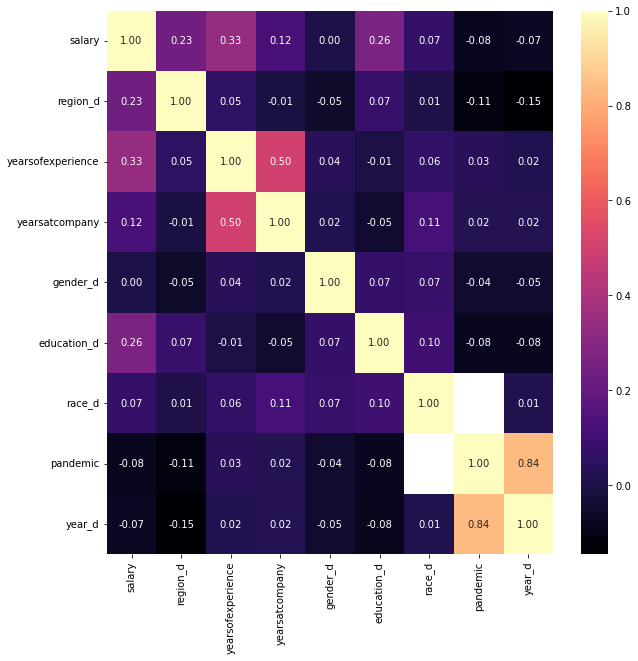

In [44]:
# Generate the correlation martices
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot = True, cmap = "magma", fmt = '.2f')

In [45]:
#create a profiling report
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Linear Regression

In [46]:
#years at company only
firstStageV1 = smf.ols(formula='salary ~ yearsatcompany',data=data).fit()

print(firstStageV1.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     31.37
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           2.41e-08
Time:                        01:55:48   Log-Likelihood:                -27042.
No. Observations:                2184   AIC:                         5.409e+04
Df Residuals:                    2182   BIC:                         5.410e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.501e+05   1668.356     89.

In [47]:
#creating years of experience square variable
data['yearsofexperienceSquare'] = data['yearsofexperience']**2

In [48]:
#years at company + years of experience
firstStageV2 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare',data=data).fit()

print(firstStageV2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.60e-65
Time:                        01:55:48   Log-Likelihood:                -26905.
No. Observations:                2184   AIC:                         5.382e+04
Df Residuals:                    2180   BIC:                         5.384e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [49]:
#years at company + years of experience + region
firstStageV3 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare + C(region_d)',data=data).fit()

print(firstStageV3.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     55.99
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.84e-109
Time:                        01:55:48   Log-Likelihood:                -26785.
No. Observations:                2184   AIC:                         5.359e+04
Df Residuals:                    2172   BIC:                         5.366e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [50]:
#years at company + years of experience + region + pandemic
firstStageV4 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare + C(region_d) + pandemic',data=data).fit()

print(firstStageV4.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     52.13
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          3.19e-110
Time:                        01:55:48   Log-Likelihood:                -26781.
No. Observations:                2184   AIC:                         5.359e+04
Df Residuals:                    2171   BIC:                         5.366e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [51]:
#years at company + years of experience + region + pandemic + education
firstStageV5 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare + C(region_d) + pandemic + C(education_d)',data=data).fit()

print(firstStageV5.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     28.65
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.60e-72
Time:                        01:55:49   Log-Likelihood:                -14100.
No. Observations:                1153   AIC:                         2.823e+04
Df Residuals:                    1136   BIC:                         2.832e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                6

In [52]:
#years at company + years of experience + region + pandemic + education + race
firstStageV6 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare + C(region_d) + pandemic + C(education_d) + C(race_d)',data=data).fit()

print(firstStageV6.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     17.72
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           8.26e-48
Time:                        01:55:49   Log-Likelihood:                -8592.9
No. Observations:                 710   AIC:                         1.723e+04
Df Residuals:                     690   BIC:                         1.732e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [53]:
#years at company + years of experience + region + pandemic + education + race + gender
firstStageV7 = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquare + C(region_d) + pandemic + C(education_d) + C(race_d) + C(gender_d)',data=data).fit()

print(firstStageV7.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     16.03
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.22e-46
Time:                        01:55:49   Log-Likelihood:                -8545.0
No. Observations:                 706   AIC:                         1.713e+04
Df Residuals:                     684   BIC:                         1.723e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                8

## Summarize the results

For dummy region:

    NewEngland: 0,
    MiddleAtlantic: 1,
    SouthAtlantic: 2,
    EastNorthCentral: 3,
    EastSouthCentral: 4,
    WestNorthCentral: 5,
    WestSouthCentral: 6,
    MOUNTAIN: 7,
    PACIFIC: 8.
    
For dummy education:

    Some College: 0,
    High school: 1,
    Bachelor's Degree: 2,
    Master's Degree: 3,
    PhD: 4.

    
For dummy race:

    Two Or More: 0,
    Black: 1,
    Hispanic: 2,
    Asian: 3,
    White: 4.
    
For dummy gender:
    
    Other: 0,
    Female: 1,
    Male: 2.
        

In [54]:
table1 = [
        ["Intercept",firstStageV1.params[0],firstStageV2.params[0], firstStageV3.params[0], firstStageV4.params[0], firstStageV5.params[0], firstStageV6.params[0], firstStageV7.params[0]],
        ["Yearsatcompany",firstStageV1.params[1],firstStageV2.params[1], firstStageV3.params[9], firstStageV4.params[9], firstStageV5.params[13], firstStageV6.params[17], firstStageV7.params[19]],
        ["Yearsofexperience",None,firstStageV2.params[2], firstStageV3.params[10], firstStageV4.params[10], firstStageV5.params[14], firstStageV6.params[18], firstStageV7.params[20]],
        ["YearsofexperienceSquared",None,firstStageV2.params[3], firstStageV3.params[11], firstStageV4.params[11], firstStageV5.params[15], firstStageV6.params[19], firstStageV7.params[21]],
        ["Region1",None,None, firstStageV3.params[1], firstStageV4.params[1], firstStageV5.params[1], firstStageV6.params[1], firstStageV7.params[1]],
        ["Region2",None,None, firstStageV3.params[2], firstStageV4.params[2], firstStageV5.params[2], firstStageV6.params[2], firstStageV7.params[2]],
        ["Region3",None,None, firstStageV3.params[3], firstStageV4.params[3], firstStageV5.params[3], firstStageV6.params[3], firstStageV7.params[3]],
        ["Region4",None,None, firstStageV3.params[4], firstStageV4.params[4], firstStageV5.params[4], firstStageV6.params[4], firstStageV7.params[4]],
        ["Region5",None,None, firstStageV3.params[5], firstStageV4.params[5], firstStageV5.params[5], firstStageV6.params[5], firstStageV7.params[5]],
        ["Region6",None,None, firstStageV3.params[6], firstStageV4.params[6], firstStageV5.params[6], firstStageV6.params[6], firstStageV7.params[6]], 
        ["Region7",None,None, firstStageV3.params[7], firstStageV4.params[7], firstStageV5.params[7], firstStageV6.params[7], firstStageV7.params[7]],        
        ["Region8",None,None, firstStageV3.params[8], firstStageV4.params[8], firstStageV5.params[8], firstStageV6.params[8], firstStageV7.params[8]],
        ["Pandemic",None,None,None, firstStageV4.params[12], firstStageV5.params[16], firstStageV6.params[20], firstStageV7.params[22]],
        ["Education1",None,None,None,None, firstStageV5.params[9], firstStageV6.params[9], firstStageV7.params[9]], 
        ["Education2",None,None,None,None, firstStageV5.params[10], firstStageV6.params[10], firstStageV7.params[10]],  
        ["Education3",None,None,None,None, firstStageV5.params[11], firstStageV6.params[11], firstStageV7.params[11]],  
        ["Education4",None,None,None,None, firstStageV5.params[12], firstStageV6.params[12], firstStageV7.params[12]], 
        ["Race1",None,None,None,None,None, firstStageV6.params[13], firstStageV7.params[13]], 
        ["Race2",None,None,None,None,None, firstStageV6.params[14], firstStageV7.params[14]],  
        ["Race3",None,None,None,None,None, firstStageV6.params[15], firstStageV7.params[15]], 
        ["Race4",None,None,None,None,None, firstStageV6.params[16], firstStageV7.params[16]],
        ["Gender1",None,None,None,None,None,None, firstStageV7.params[17]],
        ["Gender2",None,None,None,None,None,None, firstStageV7.params[18]],
        ["Observations",2184,2184,2184,2184,1153,710,706]]

headers1 = ["Variable", "Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]

print(tabulate(table1, headers1, tablefmt="github"))

| Variable                 |    Model1 |     Model2 |    Model3 |     Model4 |     Model5 |     Model6 |     Model7 |
|--------------------------|-----------|------------|-----------|------------|------------|------------|------------|
| Intercept                | 150051    | 124508     | 106867    | 112691     |  67022.2   |  17936     |   8294.21  |
| Yearsatcompany           |   3050.17 |  -2165.58  |  -1352.52 |  -1364.07  |  -1018.5   |  -1808.93  |  -1838.61  |
| Yearsofexperience        |           |   9119.43  |   8158.73 |   8240.39  |   8145.74  |   8053.43  |   8099.22  |
| YearsofexperienceSquared |           |   -228.227 |   -189.17 |   -192.207 |   -192.501 |   -158.609 |   -162.373 |
| Region1                  |           |            |  12658.2  |  12475.1   |  10920.6   |   9818.02  |  10093.8   |
| Region2                  |           |            | -16569.4  | -16278.1   | -23309.6   | -20933     | -21073.3   |
| Region3                  |           |            | -1

In [55]:
table2 = [["R^2",firstStageV1.rsquared,firstStageV2.rsquared, firstStageV3.rsquared, firstStageV4.rsquared, firstStageV5.rsquared, firstStageV6.rsquared, firstStageV7.rsquared],
        ["AdjustR^2",firstStageV1.rsquared_adj,firstStageV2.rsquared_adj, firstStageV3.rsquared_adj, firstStageV4.rsquared_adj, firstStageV5.rsquared_adj, firstStageV6.rsquared_adj, firstStageV7.rsquared_adj],
        ["Observations",2184,2184, 2184, 2184, 1153, 710, 706]]
        
headers2 = ["Indicators", "Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]

print(tabulate(table2, headers2, tablefmt="simple"))

Indicators          Model1       Model2       Model3       Model4       Model5      Model6      Model7
------------  ------------  -----------  -----------  -----------  -----------  ----------  ----------
R^2              0.0141709     0.130005     0.220913     0.223673     0.287504    0.327895    0.329823
AdjustR^2        0.0137191     0.128807     0.216967     0.219382     0.277468    0.309388    0.309247
Observations  2184          2184         2184         2184         1153         710         706


### Analysis
According to the adjusted R^2 and p-values, model 4 is the best fit model for this dataset. 
* The adjusted R^2 is increasing from model 1 to model 6, while it is decreasing from model 6 to model 7. 
* In model 5 and 6, the added variable education and race have p-values greater than 0.05
Therefore, it can be concluded even though the adjusted R^2 increase from model 4 to model 5 and 6, the variables added to the model are not significant.

1. Intercept

The intercept is positive. As the explained proportion of variance increases from model 1 to model 4, the intercept changes to 112,691. It denotes when all other independent variables equal 0, the total yearly compensation is $112,691 for a data scientist.

2. Year at company 

Year at company has a negative effect to total yearly compensation. When the data scientist year at company increases by 1 unit, the total yearly compensation decreases by $1,364.07.

3. Year of experience

Year of experience has a positive effect to to total yearly compensation. When the data scientist year of experience increases by 1 unit, the total yearly compensation increases by $8,240.39.

4. Year of experience squared (diminishing returns)

Year of experience has a diminishing returns effect. Suppose using model 4 to do the estimation, we set a model only contains year of experience and year of experience squared as the independent variables.

y = 8240.39 * experience - 192.207 * experience^2;

y' = 8240.39 - 384.414 * experience = 0;

experience = 21.44.

The year of experience will have a positive return until the experience equals 21.44.

5. Region

* Region 1 (MiddleAtlantic)

The p-value for Middle Atlantic division is greater than 0.054. Therefore, we conclude region 1 is marginally significant. 

* Region 2 (SouthAtlantic)

The average yearly total compensation in South Atlantic is $16,278.1 lower than New England.(with all other variables fixed)

* Region 3 (EastNorthCentral)

The p-value for East North Central division is 0.163. Therefore, East North Central is not statistically significant. 

* Region 4 (EastSouthCentral)

The average yearly total compensation in East South Central is $40,411.8 lower than New England.(with all other variables fixed)

* Region 5 (WestNorthCentral)

The p-value for West North Central division is 0.131. Therefore, we conclude region 5 is not significant.

* Region 6 (WestSouthCentral)

The p-value for West South Central division is 0.076. Therefore, we conclude West South Central is marginally significant. 

* Region 7 (MOUTAIN)

The p-value for Moutain division is 0.075. Therefore, we conclude Moutain is marginally significant. 

* Region 8 (PACIFIC)

The average yearly total compensation in Pacific is $29,564.2 higher than New England.(with all other variables fixed)

6. Pandemic

The average salary for a data scientist after pandemic is $7,242.1 lower than the salary before pandemic.

7. Education

From model 5 p-values for Education dummy variables, the education variable is not significant in perdicting a data scientist's salary at 95% confidence interval.

8. Race

From model 6 p-values for Race dummy variables, the race variable is also not significant in predicting a data sceintist's salary at 95% confidence interval.

9. Gender:

According to both the adjusted R^2 and p-values for Gender dummy variables in model 7, Gender is not significant in predicting a data scientist's salary.


### Visualize linear regression based on divisions (model 4)

Suppose an individual with 0 year at the company and 0 year of experience, what will be the earnings in 9 different divisions after pandemic? 

In [56]:
#salaries after pandemic
aNewEngland = 112691 - 7242.1
aMiddleAtlantic = 112691 + 12475.1*1 - 7242.1 #not significant
aSouthAtlantic = 112691 - 16278.1*1 - 7242.1 
aEastNorthCentral = 112691 - 11330.6*1 - 7242.1 
aEastSouthCentral = 112691 - 40411.8*1 - 7242.1 
aWestNorthCentral = 112691 - 22522*1 - 7242.1 #not significant
aWestSouthCentral = 112691 - 13764.6*1 - 7242.1 #not significant
aMOUTAIN = 112691 - 16965.7*1 - 7242.1 
aPACIFIC = 112691 + 29564.2*1 - 7242.1 


In [57]:
#show the counts for each region
region = pd.crosstab(index=df_ds['region'], columns='count')
region

col_0             count
region                 
EastNorthCentral     80
EastSouthCentral      8
MOUTAIN              46
MiddleAtlantic      291
NewEngland           80
PACIFIC            1443
SouthAtlantic       125
WestNorthCentral     14
WestSouthCentral     97

In [58]:
data = {'region': ['NewEngland', 'MiddleAtlantic','SouthAtlantic','EastNorthCentral','EastSouthCentral','WestNorthCentral', 'WestSouthCentral', 'MOUTAIN', 'PACIFIC'], 
        'salary': [aNewEngland, aMiddleAtlantic, aSouthAtlantic, aEastNorthCentral, aEastSouthCentral, aWestNorthCentral, aWestSouthCentral, aMOUTAIN, aPACIFIC],
        'counts': [80, 291, 125, 80, 8, 14, 97, 46, 1443]
       }

#create region dataframe for visualization          
df_region = pd.DataFrame(data)

#add the square count column for visualization
df_region['squarecounts'] = df_region['counts']**(1/2)

df_region

region    salary  counts  squarecounts
0        NewEngland  105448.9      80      8.944272
1    MiddleAtlantic  117924.0     291     17.058722
2     SouthAtlantic   89170.8     125     11.180340
3  EastNorthCentral   94118.3      80      8.944272
4  EastSouthCentral   65037.1       8      2.828427
5  WestNorthCentral   82926.9      14      3.741657
6  WestSouthCentral   91684.3      97      9.848858
7           MOUTAIN   88483.2      46      6.782330
8           PACIFIC  135013.1    1443     37.986840

In [59]:
#add longitude and latitude for regions
df_region.loc[df_region["region"] == 'NewEngland', 'latitude'] = 43.88
df_region.loc[df_region["region"] == 'NewEngland', 'longitude'] = -71.56

df_region.loc[df_region["region"] == 'MiddleAtlantic', 'latitude'] = 41.43
df_region.loc[df_region["region"] == 'MiddleAtlantic', 'longitude'] = -77.46

df_region.loc[df_region["region"] == 'SouthAtlantic', 'latitude'] = 35.05
df_region.loc[df_region["region"] == 'SouthAtlantic', 'longitude'] = -81.15

df_region.loc[df_region["region"] == 'EastNorthCentral', 'latitude'] = 41.64
df_region.loc[df_region["region"] == 'EastNorthCentral', 'longitude'] = -87.13

df_region.loc[df_region["region"] == 'EastSouthCentral', 'latitude'] = 34.14
df_region.loc[df_region["region"] == 'EastSouthCentral', 'longitude'] = -88.24

df_region.loc[df_region["region"] == 'WestNorthCentral', 'latitude'] = 42.79
df_region.loc[df_region["region"] == 'WestNorthCentral', 'longitude'] = -97.12

df_region.loc[df_region["region"] == 'WestSouthCentral', 'latitude'] = 32.69
df_region.loc[df_region["region"] == 'WestSouthCentral', 'longitude'] = -97.76

df_region.loc[df_region["region"] == 'MOUTAIN', 'latitude'] = 40.81
df_region.loc[df_region["region"] == 'MOUTAIN', 'longitude'] = -111.33

df_region.loc[df_region["region"] == 'PACIFIC', 'latitude'] = 40.74
df_region.loc[df_region["region"] == 'PACIFIC', 'longitude'] = -122.31

In [60]:
#import map
region = Map(center=(38, -98), zoom = 4)
#add full screen control
region.add_control(FullScreenControl())

In [61]:
#add boundries for divisions    
with open('us_division.json', 'r', encoding = 'utf-8') as f:
    data = json.load(f)

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }

geo_json = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    },
    style_callback=random_color
)
region.add_layer(geo_json)

In [62]:
#add markers on map
##marker 1 for region counts circles
##marker 2 for region mean salaries
mrk1 = [];
mrk2 = [];

for data,row in df_region.iterrows():
    mrk1.append(CircleMarker(location = (row.latitude,row.longitude),radius = int(row.squarecounts)))
    mrk2.append(Marker(location=(row.latitude,row.longitude),title=str(round(row.salary, 2))))
                
marker_cluster1 = MarkerCluster(markers=mrk1)
marker_cluster2 = MarkerCluster(markers=mrk2)

region.add_layer(marker_cluster1);
region.add_layer(marker_cluster2);

region

Map(center=[38, -98], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

# Discussion

### Years at Company

I visualized the distribution of years at the company in scatter plot to find if there are any outliers.

In [63]:
company = pd.DataFrame(df_ds.groupby(['yearsatcompany'])['salary'].mean()).reset_index()
company1 = pd.crosstab(index=df_ds['yearsatcompany'], columns='count').reset_index()
company['count'] = company1['count']

company

yearsatcompany         salary  count
0             0.00  148462.246777    543
1             0.20  117000.000000      1
2             0.25  140000.000000      3
3             0.30  128000.000000      1
4             0.50  148222.222222      9
5             0.70  189000.000000      1
6             1.00  147201.629328    491
7             1.50  149363.636364     11
8             2.00  158249.452954    457
9             2.50  160333.333333      9
10            2.70  120000.000000      1
11            3.00  165613.970588    272
12            3.50  208000.000000      1
13            3.70  208000.000000      1
14            4.00  173560.509554    157
15            5.00  171011.494253     87
16            6.00  164150.943396     53
17            7.00  178100.000000     30
18            8.00  154250.000000      8
19            9.00  186666.666667      6
20           10.00  163285.714286     14
21           11.00  160125.000000      8
22           12.00  153800.000000      5
23           13.00  159500.000000      6
24           14.00  185000.000000      2
25           15.00  190000.000000      3
26           16.00  135000.000000      1
27           19.00  156500.000000      2
28           20.00  159000.000000      1

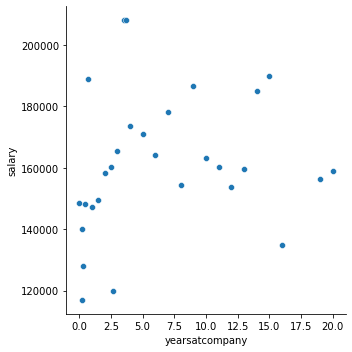

In [64]:
sns.relplot(data=company, x="yearsatcompany", y="salary")

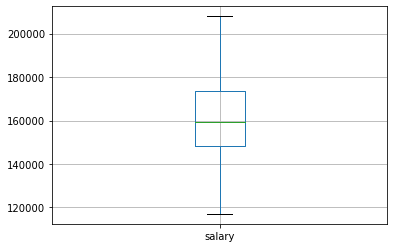

In [65]:
boxplot1 = company.boxplot(column=['salary'])

In [66]:
#Angle-Based Outlier Detection (ABOD)
outliers_fraction = 0.05
abod_company = ABOD(contamination=outliers_fraction)
abod_company.fit(company[['yearsatcompany', 'salary']])
#return classified outlier
company['ABOD'] = abod_company.labels_
abod_company.labels_

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

<AxesSubplot:xlabel='yearsatcompany', ylabel='salary'>

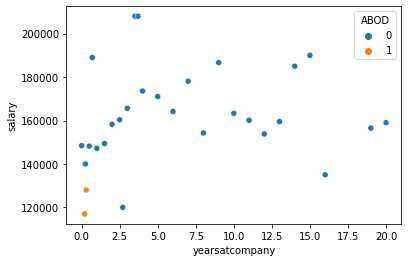

In [67]:
sns.scatterplot(data = company, x = 'yearsatcompany', y = 'salary', hue = 'ABOD')

In [68]:
company

yearsatcompany         salary  count  ABOD
0             0.00  148462.246777    543     0
1             0.20  117000.000000      1     1
2             0.25  140000.000000      3     0
3             0.30  128000.000000      1     1
4             0.50  148222.222222      9     0
5             0.70  189000.000000      1     0
6             1.00  147201.629328    491     0
7             1.50  149363.636364     11     0
8             2.00  158249.452954    457     0
9             2.50  160333.333333      9     0
10            2.70  120000.000000      1     0
11            3.00  165613.970588    272     0
12            3.50  208000.000000      1     0
13            3.70  208000.000000      1     0
14            4.00  173560.509554    157     0
15            5.00  171011.494253     87     0
16            6.00  164150.943396     53     0
17            7.00  178100.000000     30     0
18            8.00  154250.000000      8     0
19            9.00  186666.666667      6     0
20           10.00  163285.714286     14     0
21           11.00  160125.000000      8     0
22           12.00  153800.000000      5     0
23           13.00  159500.000000      6     0
24           14.00  185000.000000      2     0
25           15.00  190000.000000      3     0
26           16.00  135000.000000      1     0
27           19.00  156500.000000      2     0
28           20.00  159000.000000      1     0

### Years of Experience

Let's also check for the situation for years of experience

In [69]:
experience = pd.DataFrame(df_ds.groupby(['yearsofexperience'])['salary'].mean()).reset_index()
experience1 = pd.crosstab(index=df_ds['yearsofexperience'], columns='count').reset_index()
experience['count'] = experience1['count']
experience

yearsofexperience         salary  count
0                 0.0  129160.714286    168
1                 1.0  128444.444444    180
2                 2.0  137634.868421    304
3                 3.0  143162.264151    265
4                 4.0  153426.829268    246
5                 5.0  161518.771331    293
6                 6.0  169546.666667    150
7                 7.0  174763.157895    114
8                 8.0  175615.384615    104
9                 9.0  179053.571429     56
10               10.0  186464.912281    114
11               11.0  184709.677419     31
12               12.0  200914.285714     35
13               13.0  176136.363636     22
14               14.0  185400.000000     10
15               15.0  200780.487805     41
16               16.0  187285.714286     14
17               17.0  194200.000000      5
18               18.0  192333.333333      3
19               19.0  200000.000000      1
20               20.0  206823.529412     17
21               21.0  200000.000000      1
22               22.0  267000.000000      2
23               23.0  170000.000000      2
24               25.0  199750.000000      4
25               30.0  250000.000000      1
26               34.0  135000.000000      1

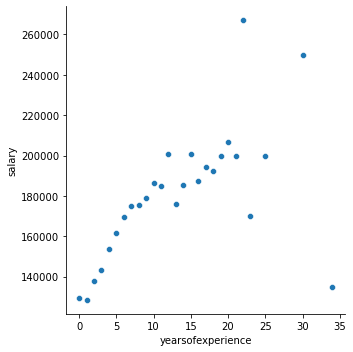

In [70]:
sns.relplot(data=experience, x="yearsofexperience", y="salary")

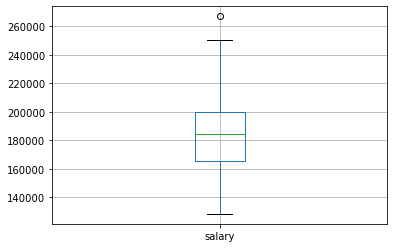

In [71]:
boxplot = experience.boxplot(column=['salary'])  

In [72]:
#Angle-Based Outlier Detection (ABOD)
outliers_fraction = 0.05
abod_experience = ABOD(contamination=outliers_fraction)
abod_experience.fit(experience[['yearsofexperience', 'salary']])
#return classified outlier
experience['ABOD'] = abod_experience.labels_
abod_experience.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0])

<AxesSubplot:xlabel='yearsofexperience', ylabel='salary'>

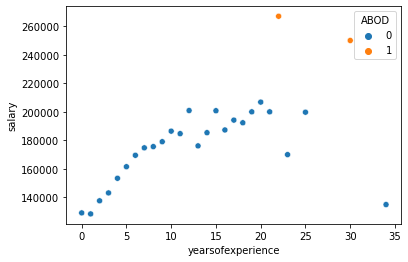

In [73]:
sns.scatterplot(data = experience, x = 'yearsofexperience', y = 'salary', hue = 'ABOD')

In [74]:
experience

yearsofexperience         salary  count  ABOD
0                 0.0  129160.714286    168     0
1                 1.0  128444.444444    180     0
2                 2.0  137634.868421    304     0
3                 3.0  143162.264151    265     0
4                 4.0  153426.829268    246     0
5                 5.0  161518.771331    293     0
6                 6.0  169546.666667    150     0
7                 7.0  174763.157895    114     0
8                 8.0  175615.384615    104     0
9                 9.0  179053.571429     56     0
10               10.0  186464.912281    114     0
11               11.0  184709.677419     31     0
12               12.0  200914.285714     35     0
13               13.0  176136.363636     22     0
14               14.0  185400.000000     10     0
15               15.0  200780.487805     41     0
16               16.0  187285.714286     14     0
17               17.0  194200.000000      5     0
18               18.0  192333.333333      3     0
19               19.0  200000.000000      1     0
20               20.0  206823.529412     17     0
21               21.0  200000.000000      1     0
22               22.0  267000.000000      2     1
23               23.0  170000.000000      2     0
24               25.0  199750.000000      4     0
25               30.0  250000.000000      1     1
26               34.0  135000.000000      1     0

## Linear regression without outliers

In [75]:
#create a new data frame to drop outliers
outliers = df_ds
outliers = outliers[outliers.yearsofexperience != 22]

outliers['yearsofexperienceSquared'] = outliers['yearsofexperience']**2

/var/folders/3n/bgfqg8rx1h30s2swb06_wwz00000gn/T/ipykernel_33920/1950368676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['yearsofexperienceSquared'] = outliers['yearsofexperience']**2


In [76]:
#years at company + years of experience + region + pandemic
secondStage = smf.ols(formula='salary ~ yearsatcompany + yearsofexperience + yearsofexperienceSquared + C(region_d) + pandemic',data=outliers).fit()

print(secondStage.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     51.50
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          5.73e-109
Time:                        01:55:59   Log-Likelihood:                -26755.
No. Observations:                2182   AIC:                         5.354e+04
Df Residuals:                    2169   BIC:                         5.361e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               